<a href="https://colab.research.google.com/github/hariharan849/Coursera-Deep-Learning/blob/master/braintumor_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rm1000_brain_tumor_mri_scans_path = kagglehub.dataset_download('rm1000/brain-tumor-mri-scans')

print('Data source import complete.')


100%|██████████| 236M/236M [00:05<00:00, 46.6MB/s]

Extracting files...


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from torchvision import datasets, transforms
import torchvision
import torch
from torch.utils.data import DataLoader, Dataset
from typing import Dict, List, Tuple
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pathlib, cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
mri_dataset_path = pathlib.Path(rm1000_brain_tumor_mri_scans_path)

images = list(mri_dataset_path.glob("*/*"))
labels = [os.path.split(os.path.dirname(image_path))[-1] for image_path in images]
class_names = [dirname for dirname in os.listdir(mri_dataset_path)]

total_images = len(images)
mri_df = pd.DataFrame(zip(images, labels), columns=["images", "labels"])
# Step 1: Create a label-to-index mapping
label_mapping = {label: idx for idx, label in enumerate(mri_df['labels'].unique())}

<ipython-input-5-878a189b4515>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(mri_df, x="labels", palette='pastel')


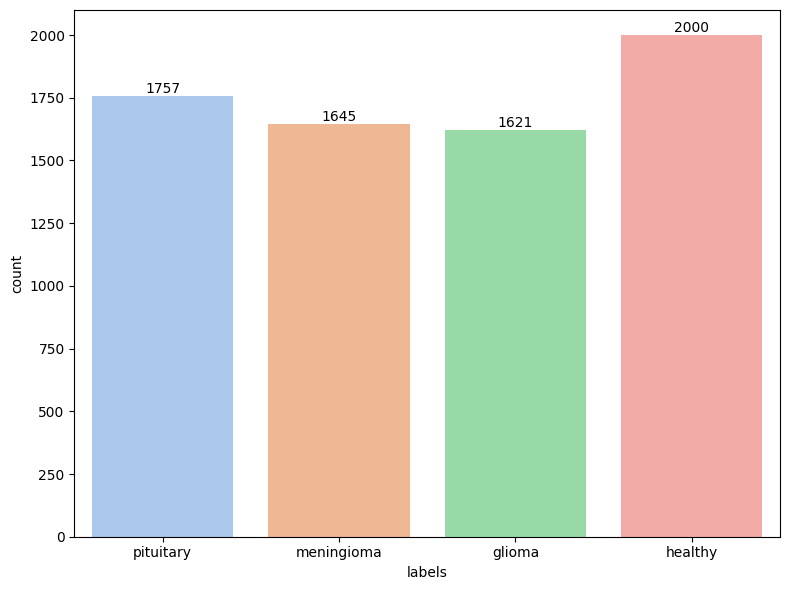

In [5]:
plt.figure(figsize=(8, 6))
# Annotate the count on top of each bar
ax = sns.countplot(mri_df, x="labels", palette='pastel')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
plt.tight_layout()

plt.show()

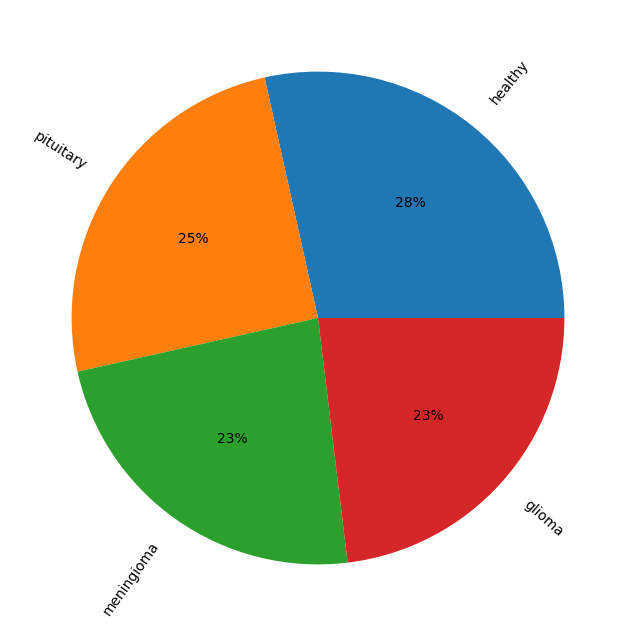

In [6]:
value_counts = mri_df["labels"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, rotatelabels=True, autopct='%.0f%%')
plt.show()

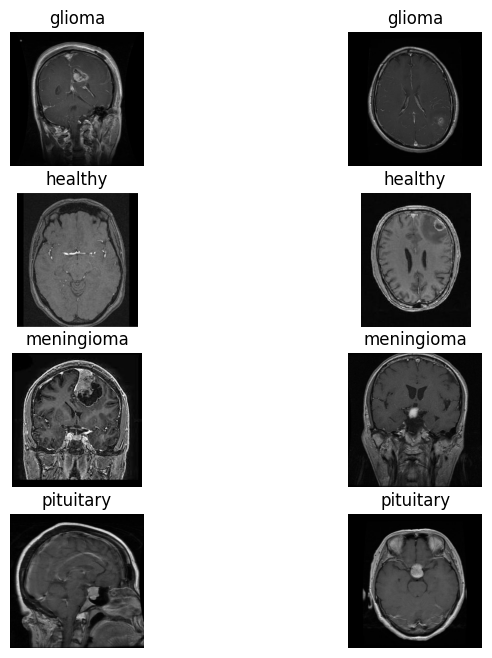

In [7]:
display_images = mri_df.sample(frac=0.1).sort_values(by="labels").groupby("labels").head(2)
plt.figure(figsize=(8, 8))
for i, (index, (image_path, label)) in enumerate(display_images.iterrows(), 1):
  image = cv2.imread(image_path)
  plt.subplot(4, 2, i)
  plt.imshow(image)
  plt.axis("off")
  plt.title(label)

In [8]:
# Splitting dataset
strat = mri_df['labels']
train_df, dummy_df = train_test_split(mri_df, test_size=.3, random_state=123, stratify=strat, shuffle=True)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=.5, random_state=123, stratify=strat, shuffle=True)

print(f"Number of Training dataset: {len(train_df)}\nNumber of Validation dataset: {len(valid_df)}\nNumber of Testing dataset: {len(test_df)}")

Number of Training dataset: 4916
Number of Validation dataset: 1053
Number of Testing dataset: 1054


In [9]:
train_df.head()

,images,labels
2974,/root/.cache/kagglehub/datasets/rm1000/brain-t...,meningioma
435,/root/.cache/kagglehub/datasets/rm1000/brain-t...,pituitary
2361,/root/.cache/kagglehub/datasets/rm1000/brain-t...,meningioma
4992,/root/.cache/kagglehub/datasets/rm1000/brain-t...,glioma
1252,/root/.cache/kagglehub/datasets/rm1000/brain-t...,pituitary


In [10]:
class BrainTumorDataset(Dataset):
  def __init__(self, dataframe, label_mapping, transforms=None):
    self._df = dataframe
    self._label_mapping = label_mapping
    self._transforms = transforms

  def __len__(self):
    return len(self._df)

  def __getitem__(self, index):
    img_path = self._df.iloc[index]["images"]
    label_str = self._df.iloc[index]["labels"]
    # Convert string label to integer using the label mapping
    label = self._label_mapping[label_str]

    # Load image
    image = Image.open(img_path).convert("RGB")  # Ensure RGB format

    # Apply transformations if any
    if self._transforms:
        # Convert PIL image to numpy array
        image = np.array(image)
        image = self._transforms(image=image)['image']

    return image, label

In [11]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = BrainTumorDataset(train_df, label_mapping, transforms=train_transform)

In [12]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = BrainTumorDataset(valid_df, label_mapping, transforms=val_transform)

In [13]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [14]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).



    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").



    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)

    """
    # Put model in train mode
    model.train()
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.
    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred_logits = model(X)
            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:

    """Trains and tests a PyTorch model.
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.
    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}

    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    # Return the filled results at the end of the epochs
    return results

In [15]:
weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()

model = torchvision.models.efficientnet_b7(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:02<00:00, 98.6MB/s]


In [16]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]

)

[INFO] Couldn't find torchinfo... installing it.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 2560, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 64, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 64, 112, 112]   1,728                True
│    │    └─BatchNorm2d (1)                                  [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    │    └─SiLU (2)                                         [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 64, 112, 112]   [32, 32, 112

In [17]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=2560,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


In [18]:
results = train(
    model, train_dl, val_dl, optimizer, loss_fn, 5, device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9591 | train_acc: 0.6439 | test_loss: 0.6536 | test_acc: 0.7864
Epoch: 2 | train_loss: 0.7540 | train_acc: 0.7115 | test_loss: 0.5423 | test_acc: 0.8084
Epoch: 3 | train_loss: 0.7115 | train_acc: 0.7241 | test_loss: 0.5121 | test_acc: 0.8206
Epoch: 4 | train_loss: 0.6881 | train_acc: 0.7399 | test_loss: 0.4925 | test_acc: 0.8277
Epoch: 5 | train_loss: 0.6646 | train_acc: 0.7424 | test_loss: 0.4739 | test_acc: 0.8296


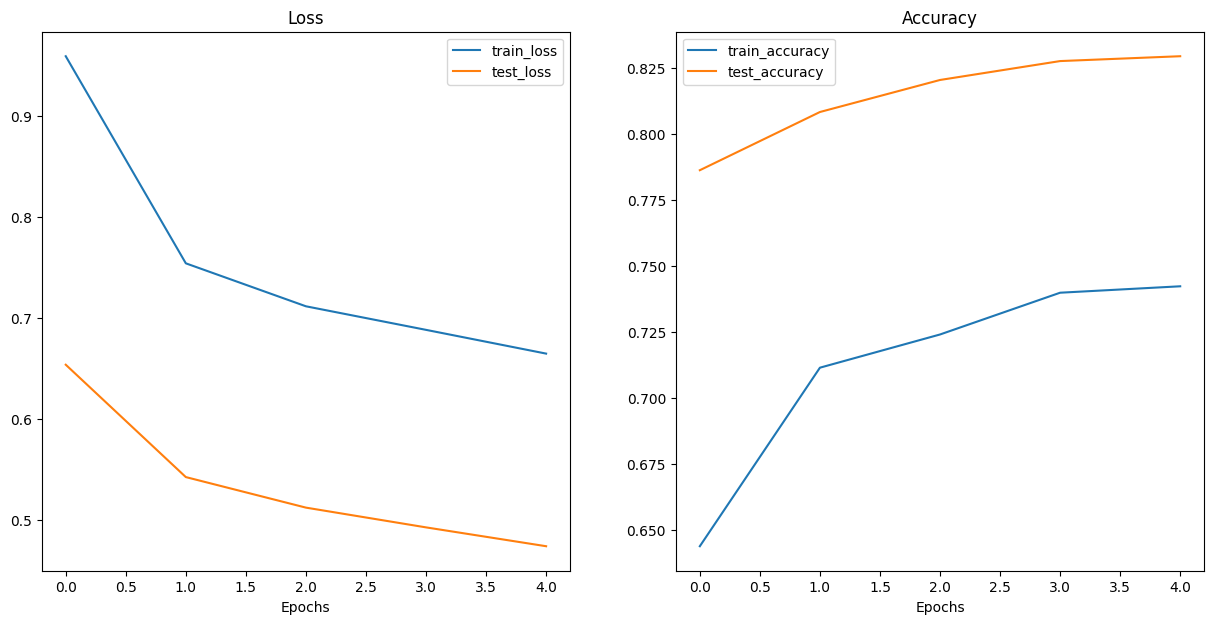

In [20]:
# Plot loss curves of a model
def plot_loss_curves(results):

    """Plots training curves of a results dictionary.
    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    epochs = range(len(results["train_loss"]))
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(results)